# VGG16 사용
* 이미지넷으로 사전 훈련된 네트워크를 사용(전이학습)
* 16개의 conv2d가 중첩된 이미지 분류 모델

1) 특성추출 방식
* 합성곱 필터링 영역(Convolutional base)를 그대로 사용
* 공통되는 특성만 추출하여 사용
* 전결합망 부분은 새로운 데이터 사용(고양이/강아지)로 학습을 다시 시킴

## 1. Google Drive와 연동

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
base_dir = '/content/gdrive/My Drive/Colab Notebooks/CNN/datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir=os.path.join(base_dir,'test')

## 2. VGG16으로 사전학습된 가중치 가져오기
* include_top은 기존의 1000개 전결합망 분류기를 포함할지 결정

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3)) # 전결합망 분류기는 따로 구현

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

특성추출 방식은 2가지 옵션 사용 가능   
방법1. 합성곱 기반을 통과한 출력을 저장한 후 이를 분류기에 통과
* 데이터 확장은 사용 할수 없음
* 하지만 실행이 빠름

방법2. 모델에 Dense망을 추가하고 학습을 수행
* 데이터 확장을 사용할 수 있음
* 비용이 많이 듬

# 방법1. 합성곱 기반을 통과한 출력을 저장한 후 이를 분류기에 통과
- 특성추출만 사용한 모델 (데이터 증식은 사용하지 않는 방식)
- ImageDataGenerator를 사용하여 이미지와 레이블을 생성
- conv_base 모델의 predict를 사용하여 이미지의 특성을 추출
- 마지막 출력의 크기가 (4, 4, 512)이다.

In [ ]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 

In [ ]:
img_width = 150
img_height = 150
batch_size=20

datagen = ImageDataGenerator(rescale = 1./255)

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))

  # ImageDataGenerator 생성
  generator = datagen.flow_from_directory(
      directory,
 	    target_size=(img_width,img_height),
      class_mode='binary',
			batch_size=batch_size)

  # ImageDataGenerator를 사용하여 이미지와 레이블을 생성
  i=1
  for inputs_batch, labels_batch in generator:
    # conv_base 모델의 predict를 사용하여 이미지의 특성을 추출
    # features_batch(마지막 출력의 크기)가 (?, ?, ?)
    features_batch = conv_base.predict(inputs_batch)
    features[i*batch_size:(i+1)*batch_size] = features_batch
    labels[i*batch_size:(i+1)*batch_size] = labels_batch
    i += 1
    if i* batch_size >= sample_count:
      break
  return features, labels

# conv_base 모델을 통과한 feature map, labels
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

# 분류기의 input이 되기 위해 1차원 탠서로 reshape
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))

# 분류기 생성 
model = models.Sequential()

model.add(layers.Dense(512, activation='relu', input_dim= 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 4,195,329
Trainable params: 4,195,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# complile
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

# fit
# dense 2개 층만 훈련하기 때문에 매우 빠름
history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data= (validation_features, validation_labels),
    batch_size=batch_size)

Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2132 - accuracy: 0.9295 - val_loss: 0.1795 - val_accuracy: 0.9310
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.0470 - accuracy: 0.9960 - val_loss: 0.1703 - val_accuracy: 0.9310
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.0251 - accuracy: 0.9990 - val_loss: 0.1702 - val_accuracy: 0.9340
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.0175 - accuracy: 0.9990 - val_loss: 0.1733 - val_accuracy: 0.9400
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.0120 - accuracy: 0.9995 - val_loss: 0.1904 - val_accuracy: 0.9400
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.1938 - val_accuracy: 0.9430
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.2189 - val_accuracy: 0.9360
Epoch 

## 성능확인

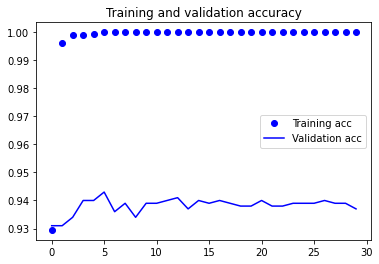

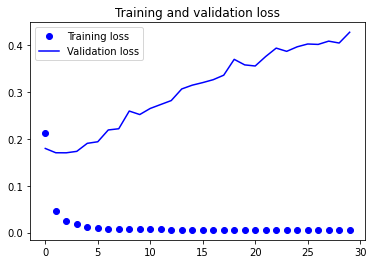

In [ ]:
# 성능확인

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 과대적합이 발생
- 훈련 데이터가 부족
- 데이터 확장을 통해 개선

# 방법2. VGG16 모델에 Dense망을 추가하여 학습
- 데이터 확장을 사용할 수 있다.
- 엔드-투-엔드 실행
- 비용이 많이 든다


## VGG16 합성곱 층기반 위에 분류기 추가


In [ ]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 

In [ ]:
# 분류기 생성 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


## 학습을 동결하지 않으면 모두 재 학습
* tranable 속성을 False로 설정하여 네트워크를 동결
* 2개의 Dense 중 가중치만 훈련

In [ ]:
print('동결 전 가중치의 종류 : ', len(model.trainable_weights))

동결 전 가중치의 종류 :  30


* 각 레이어 별로 2종류(w:가중치, b:편향)의 학습 가능한 가중치 존재(VGG16:26(13 * 2) / 분류기 4(2 * 2)

In [ ]:
conv_base.trainable = False

print('conv_base layer 동결 후 훈련 가능 가중치 종류:', len(model.trainable_weights))

conv_base layer 동결 후 훈련 가능 가중치 종류: 4


* 각 레이어 별로 2종류(w:가중치, b: 편향)의 학습 가능한 가중치 존재(분류기 : 4(2*2))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


## 데이터 전처리

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   shear_range=0.1, 
                                   zoom_range=0.1,
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150,150), batch_size=20,class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=(150,150), batch_size=20,class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150,150), batch_size=20,class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 모델 훈련

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 213s 2s/step - loss: 0.6363 - accuracy: 0.6430 - val_loss: 0.4634 - val_accuracy: 0.8300
Epoch 2/30
100/100 [==============================] - 21s 205ms/step - loss: 0.5016 - accuracy: 0.7600 - val_loss: 0.3859 - val_accuracy: 0.8410
Epoch 3/30
100/100 [==============================] - 21s 205ms/step - loss: 0.4374 - accuracy: 0.7960 - val_loss: 0.3616 - val_accuracy: 0.8350
Epoch 4/30
100/100 [==============================] - 20s 205ms/step - loss: 0.3951 - accuracy: 0.8195 - val_loss: 0.3183 - val_accuracy: 0.8780
Epoch 5/30
100/100 [==============================] - 21s 208ms/step - loss: 0.3603 - accuracy: 0.8385 - val_loss: 0.3088 - val_accuracy: 0.8740
Epoch 6/30
100/100 [==============================] - 21s 206ms/step - loss: 0.3518 - accuracy: 0.8455 - val_loss: 0.2871 - val_accuracy: 0.8970
Epoch 7/30
100/100 [==============================] - 21s 208ms/step - loss: 0.3274 - accuracy: 0.8630 - val_loss: 0.2781 - val_accu

In [ ]:
model.evalute()

## 성능 시각화

In [ ]:
import matplotlib.pyplot as plt

acc    = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

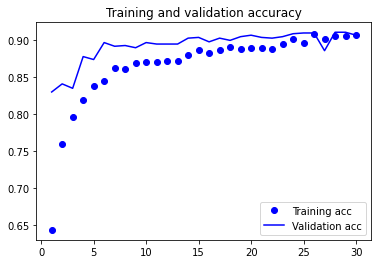

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

* acc와 val_acc 모두 증가하는 경향을 보아 과적합이 발생하지 않았음

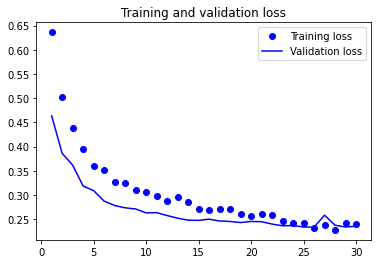

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('/content/gdrive/My Drive/Colab Notebooks/CNN/datasets/cats_and_dogs_small_vgg16_way2.h5')

# 미세 조정

성능 향상을 위해 '미세 조정'
* 특성 추출을 보완하는 fine-tunning
* 특성 추출에 사용했던 동결 모델(VGG16)의 상위 층 몇 개를 동결에서 해제
* 재사용 모델의 표현을 일부 조정하기 때문에 미세 조정이라고 부름
* 미세 조정하는 단계
1. VGG16 위에 분류기를 추가한다.
2. VGG16을 동결한다
3. 분류기를 훈련한다
4. VGG16 중에 일부 층의 동결을 해제한다
5. VGG16층 동결 해제한 층과 분류기를 함께 훈련한다

* step3 분류기를 미리 훈련하는 이유 : 분류기가 미리 훈련되지 않으면 훈련되는 동안 너무 큰 오차 신호가 네트워크에 전파됨. 미세 조정될 층들의 학습한 표현을 망가뜨릴 수 있음
* step3 까지는 이미 완료했으므로 step 4부터 진행

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


위에서 block5 부분만 미세조정
* 합성곱 기반층에 있는 하위층들이 좀 더 일반적이고 재사용 가능한 특성을 인코딩
* 반면 상위층은 좀 더 특화된 특성을 인코딩
* 즉 새로운 문제에는 구체적인 특성이 필요
* 훈련해야 할 파라미터가 많으면 과대적합의 위험이 커짐
* 작튼 데이터 셋에 약 1500만 개의 파라미터는 위험

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1' :
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = True   

* 94%의 테스트 정확도 - 향상
* 손실이 감소되지 않았는데 어떻게 정확도가 향상될 수 있는가?
* 손실그래프는 개별적인 손실 값의 평균을 그린 것이다.
* 하지만 정확도에 영향을 미치는 것은 손실 값의 분포이지 평균이 아니다.
* 정확도는 모델이 예측한 클래스 확률이 어떤 임계값을 넘었는지에 대한 결과이다.
* 즉, 모델이 향상되더라도 평균 손실에 반영되지 않을 수 있다.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)
test_loss, test_accuracy = model.evaluate_generator(test_generator)

print(test_accuracy)
print(test_loss)